In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from bbox_plotter import yolo_to_corners
from torchvision.ops import complete_box_iou_loss
import numpy as np
import csv
import os
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ZebrafishDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 128 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=4)
        
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.global_avg_pool(self.pool3(torch.relu(self.conv3(x))))
                
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
        

In [4]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [5]:
class CompleteBoxLoss(nn.Module):
    def __init__(self):
        super(CompleteBoxLoss, self).__init__()

    def forward(self, pred_boxes, true_boxes, reduction):
        ciou = complete_box_iou_loss(pred_boxes, true_boxes, reduction)
        
        return ciou


In [6]:
def Initialize_writer(file_path,columns = ['epoch','loss','val_loss']):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(columns)

In [7]:
images_path = "D:\Praharsha\Code\CAMZ\data\interim\X_labelled_data.npy"
labels_path = "D:\Praharsha\Code\CAMZ\data\interim\y_labelled_data.npy"

transform = transforms.ToTensor()
dataset = ZebrafishDataset(images_path, labels_path, transform=transform)

In [8]:
k_folds = 5
num_epochs = 200
loss_function = CompleteBoxLoss()
batch_size = 32

In [12]:
kfold = KFold(n_splits=k_folds, shuffle=True)

fold_results = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold: {fold+1}")
    print('-----------------------------------------------------------------------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)
    
    model = CNNModel().to('cuda')
    print("Resetting the model for upcoming training session")
    model.apply(reset_weights)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epoch_history_csv_path = rf"D:\Praharsha\Code\CAMZ\models\CrossValidation_history\fold_{fold+1}\epoch_history"
    batch_train_history_csv_path = rf"D:\Praharsha\Code\CAMZ\models\CrossValidation_history\fold_{fold+1}\batch_train_history" #____________
    batch_val_history_csv_path = rf"D:\Praharsha\Code\CAMZ\models\CrossValidation_history\fold_{fold+1}\batch_val_history" #______________

    Initialize_writer(epoch_history_csv_path)
    Initialize_writer(batch_train_history_csv_path,columns=['epoch', 'batch', 'loss'])  #_____________
    Initialize_writer(batch_val_history_csv_path, columns=['epoch','batch','loss']) # _____________
    
    best_val_ciou_loss = float('inf')
    
    for epoch in range(num_epochs):
        #Training Pipeline
        model.train()
        ciou_total_batch_loss = 0.0

        ciou_loss_per_batch_train_history = []  #___________
        batch_num = 1  #____________
         
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            
            norm_labels = yolo_to_corners(labels, image_width=720, image_height=720)
            outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
                     
            
            ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')
            
            ciou_loss_per_batch.backward()
            
            optimizer.step()
            
            ciou_loss_per_batch_train_history.append([epoch, batch_num, ciou_loss_per_batch.item()])  #____________

            ciou_total_batch_loss += ciou_loss_per_batch.item()

            batch_num += 1  #_______________
        
        ciou_loss_per_epoch = ciou_total_batch_loss / len(train_loader)
        
        print(end='\n')
        print(f"Fold [{fold+1}/{k_folds}], Epoch [{epoch+1}/{num_epochs}], CIoU: {ciou_loss_per_epoch:.4f}", end=" --- ")
        
        # Validation Pipeline
        model.eval()
        ciou_total_batch_loss = 0.0
        
        ciou_loss_per_batch_val_history = []  #___________
        batch_num = 1  #____________

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                norm_labels = yolo_to_corners(labels, image_width=720, image_height=720)
                outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
                
                ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')

                ciou_loss_per_batch_val_history.append([epoch, batch_num, ciou_loss_per_batch.item()])  #______________

                ciou_total_batch_loss += ciou_loss_per_batch.item()

                batch_num += 1  #_____________
        
        val_ciou_loss = ciou_total_batch_loss / len(test_loader)
        print(f"Validation for Epoch [{epoch+1}/{num_epochs}], CIoU: {val_ciou_loss}")
        
        # Save model for this epoch if it's the best so far
        if val_ciou_loss < best_val_ciou_loss:
            best_val_ciou_loss = val_ciou_loss
            torch.save(model.state_dict(), f'D:\Praharsha\Code\CAMZ\models\model_fold_{fold + 1}.pth')
            print(f"Saving best model for Fold {fold + 1} at Epoch {epoch + 1}")


        with open(epoch_history_csv_path, mode='a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerow([epoch+1, ciou_loss_per_epoch, val_ciou_loss])

        #_______________
        with open(batch_train_history_csv_path,'a',newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerows(ciou_loss_per_batch_train_history)

        #_______________
        with open(batch_val_history_csv_path, 'a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerows(ciou_loss_per_batch_val_history)

    print(f"Best Validation CIoU for Fold {fold + 1}: {best_val_ciou_loss:.4f}")


    fold_results.append((fold + 1, best_val_ciou_loss))

# Print all results at the end
print("\nK-Fold Cross-Validation Results:")
print("Fold\tBest Validation CIoU Loss")
for fold, best_loss in fold_results:
    print(f"{fold}\t{best_loss:.4f}")

# Print the average CIoU loss across folds
avg_val_ciou_loss = sum(loss for _, loss in fold_results) / k_folds
print(f"\nAverage Validation CIoU Loss Across All Folds: {avg_val_ciou_loss:.4f}")


Fold: 1
-----------------------------------------------------------------------------------------
Resetting the model for upcoming training session


C:\Users\USER\AppData\Local\Temp\ipykernel_35596\2341323471.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)



Fold [1/5], Epoch [1/200], CIoU: 1.0334 --- Validation for Epoch [1/200], CIoU: 1.027786374092102
Saving best model for Fold 1 at Epoch 1

Fold [1/5], Epoch [2/200], CIoU: 1.0246 --- Validation for Epoch [2/200], CIoU: 1.0245594263076783
Saving best model for Fold 1 at Epoch 2

Fold [1/5], Epoch [3/200], CIoU: 1.0247 --- Validation for Epoch [3/200], CIoU: 1.0260937929153442

Fold [1/5], Epoch [4/200], CIoU: 1.0245 --- Validation for Epoch [4/200], CIoU: 1.0244924068450927
Saving best model for Fold 1 at Epoch 4

Fold [1/5], Epoch [5/200], CIoU: 1.0249 --- Validation for Epoch [5/200], CIoU: 1.025130558013916

Fold [1/5], Epoch [6/200], CIoU: 1.0242 --- Validation for Epoch [6/200], CIoU: 1.024230130513509
Saving best model for Fold 1 at Epoch 6

Fold [1/5], Epoch [7/200], CIoU: 1.0240 --- Validation for Epoch [7/200], CIoU: 1.0256725549697876

Fold [1/5], Epoch [8/200], CIoU: 1.0238 --- Validation for Epoch [8/200], CIoU: 1.024448561668396

Fold [1/5], Epoch [9/200], CIoU: 1.0194 ---

In [13]:
train_loss_list = []
val_loss_list = []
epoch_loss_list = []

for i in range(5):
    fold_training_path = rf"D:\Praharsha\code\CAMZ\models\CrossValidation_history\fold_{i+1}\batch_train_history"
    fold_val_path = rf"D:\Praharsha\code\CAMZ\models\CrossValidation_history\fold_{i+1}\batch_val_history"
    fold_epoch_path = rf"D:\Praharsha\code\CAMZ\models\CrossValidation_history\fold_{i+1}\epoch_history"

    train_loss_list.append(pd.read_csv(fold_training_path))
    val_loss_list.append(pd.read_csv(fold_val_path))
    epoch_loss_list.append(pd.read_csv(fold_epoch_path))
    
    train_loss_list[i]['batch'] = range(0, len(train_loss_list[i]))
    val_loss_list[i]['batch']  = np.linspace(0, len(train_loss_list[i]), len(val_loss_list[i]))
    epoch_loss_list[i]['epoch'] = np.linspace(0,len(train_loss_list[i]), 200)

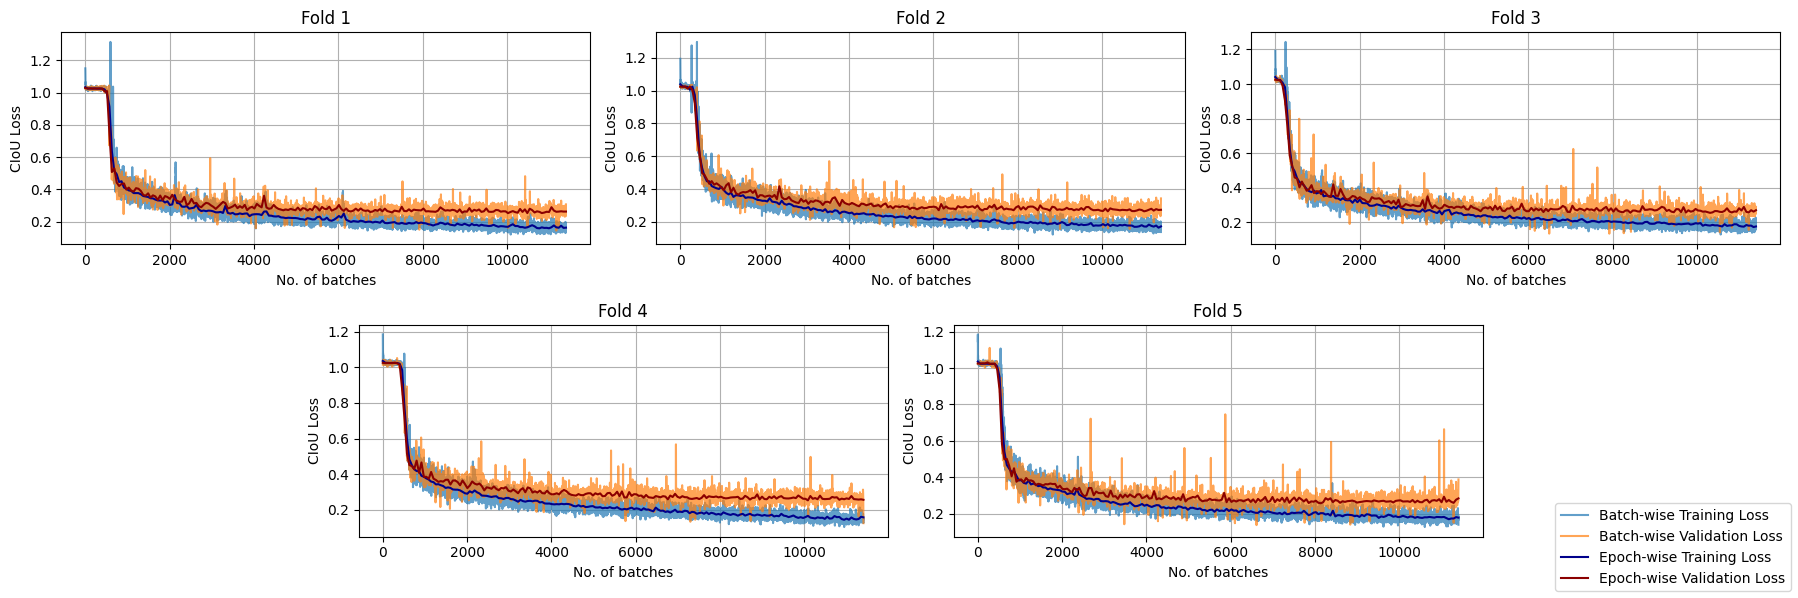

In [14]:
fig= plt.figure(figsize=(18, 6))

indices = [(1,2),(3,4),(5,6),(8,9),(10,11)]

for i in range(5):

    plt.subplot(2,6,indices[i])
    plt.title(f'Fold {i+1}')
    plt.plot(train_loss_list[i]['batch'], train_loss_list[i]['loss'],label='Batch-wise Training Loss',alpha = 0.7)
    plt.plot(val_loss_list[i]['batch'], val_loss_list[i]['loss'],label='Batch-wise Validation Loss',alpha = 0.7)

    plt.xlabel('No. of batches')
    plt.ylabel('CIoU Loss')

    plt.plot(epoch_loss_list[i]['epoch'],epoch_loss_list[i]['loss'],label = 'Epoch-wise Training Loss', color = 'darkblue')
    plt.plot(epoch_loss_list[i]['epoch'], epoch_loss_list[i]['val_loss'], label='Epoch-wise Validation Loss', color = 'darkred')
    plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()

fig.legend(handles, labels, loc='lower right')

plt.tight_layout()